## Importing Libraries

In [4]:
# Pake yang ini
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler


from fast_ml.model_development import train_valid_test_split


## Data Extraction

In [15]:
TRAIN_PATH = r'../../Datasets/train.csv'
TEST_PATH = r'../../Datasets/test.csv'
SAMPLE_SUBMISSION_PATH = r"../../Datasets/sample_submission.csv"

In [16]:
train_dat = pd.read_csv(TRAIN_PATH)
test_dat = pd.read_csv(TEST_PATH)

In [17]:
train_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

## Data Prep


In [18]:
#drop id
train_dat = train_dat.drop(columns='id')
test_dat = test_dat.drop(columns='id')


### Null Handling

In [19]:
# drop all null values
train_dat = train_dat.fillna(train_dat.mean())
test_dat = test_dat.fillna(test_dat.mean())

train_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  object 
 1   loading         26570 non-null  float64
 2   attribute_0     26570 non-null  object 
 3   attribute_1     26570 non-null  object 
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26570 non-null  float64
 10  measurement_4   26570 non-null  float64
 11  measurement_5   26570 non-null  float64
 12  measurement_6   26570 non-null  float64
 13  measurement_7   26570 non-null  float64
 14  measurement_8   26570 non-null  float64
 15  measurement_9   26570 non-null  float64
 16  measurement_10  26570 non-null  float64
 17  measurement_11  26570 non-null 

### Encoding

#### One hot encoding

In [20]:
# # Perform one-hot encoding
# train_dat = pd.get_dummies(train_dat, columns=['attribute_0', 'attribute_1'])
# test_dat = pd.get_dummies(test_dat, columns=['attribute_0', 'attribute_1'])

#### Label Encoding

In [23]:
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [24]:
cat_features = ['product_code','attribute_0', 'attribute_1' ]
train_dat, test_dat = label_encoder(train_dat, test_dat, cat_features)

## SPLIT TRAIN AND TEST

In [25]:
# Train test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(
                                        train_dat,
                                        target = 'failure',
                                        train_size=0.7,
                                        random_state=42,
                                        )

# Memisahkan fitur dengan target
full_train = train_dat.drop(columns=["failure"])
full_target = train_dat["failure"]

## FEATURE SCALING

In [26]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
print(X_train.shape)
print(X_test.shape)

(18599, 24)
(3986, 24)


#  MODEL

### SVM, KNN, Naive Bayes

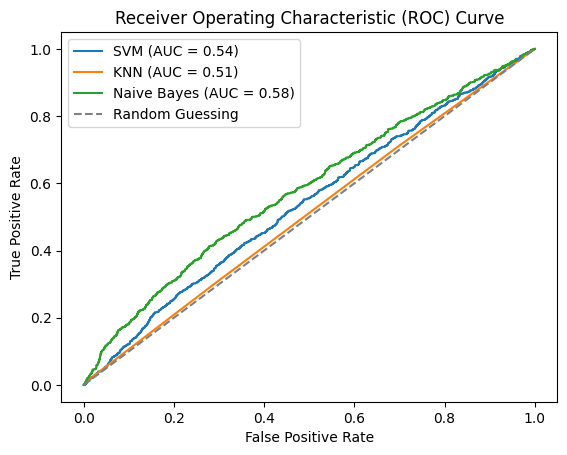

In [29]:
# Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_scores = svm_model.decision_function(X_test)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_scores)
svm_auc = roc_auc_score(y_test, svm_scores)
plt.plot(svm_fpr, svm_tpr, label="SVM (AUC = {:.2f})".format(svm_auc))

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_scores = knn_model.predict_proba(X_test)[:, 1]  # KNN can directly provide probabilities
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_scores)
knn_auc = roc_auc_score(y_test, knn_scores)
plt.plot(knn_fpr, knn_tpr, label="KNN (AUC = {:.2f})".format(knn_auc))

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_probs = nb_model.predict_proba(X_test)[:, 1]
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
plt.plot(nb_fpr, nb_tpr, label="Naive Bayes (AUC = {:.2f})".format(nb_auc))

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guessing')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Kaggle Submission


In [39]:
submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
submission['failure'] = nb_model.predict(test_dat)
submission.to_csv('../submissions/submission_2.csv', index=False)